In [3]:
### Display
from IPython.display import display
## Data Handling
import pandas as pd
import pm4py
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
import numpy as np
from cvxopt.misc_solvers import scale

In [4]:
# please do not change or delete this cell (probably not needed, but just in case ;))
random.seed(42)
np.random.seed(42)

In [5]:
log = pm4py.read_xes('fines_event_log.xes', variant="rustxes")
log

,paymentAmount,dismissal,case:concept:name,time:timestamp,concept:name,case:fine,expense,penalty
0,NaN,None,A1,2006-07-23 22:00:00+00:00,Create Fine,3500,NaN,NaN
1,NaN,None,A1,2006-12-04 23:00:00+00:00,Send Fine,3500,1100.0,NaN
2,NaN,None,A10008,2007-03-19 23:00:00+00:00,Create Fine,3600,NaN,NaN
3,NaN,None,A10008,2007-07-16 22:00:00+00:00,Send Fine,3600,1300.0,NaN
4,NaN,None,A10008,2007-08-01 22:00:00+00:00,Insert Fine Notification,3600,NaN,NaN
...,...,...,...,...,...,...,...,...
267247,NaN,None,V9999,2002-09-06 22:00:00+00:00,Create Fine,13100,NaN,NaN
267248,NaN,None,V9999,2002-10-24 22:00:00+00:00,Send Fine,13100,1516.0,NaN
267249,NaN,None,V9999,2002-11-03 23:00:00+00:00,Insert Fine Notification,13100,NaN,NaN
267250,NaN,None,V9999,2003-01-02 23:00:00+00:00,Add penalty,13100,NaN,13100.0


In [6]:
# number of cases
number_cases = log["case:concept:name"].nunique()
number_cases

71522

In [7]:
number_activities = log["concept:name"].nunique()
number_activities

11

In [8]:
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.util import dataframe_utils

print("pm4py version:", pm4py.__version__ if hasattr(pm4py, "__version__") else "unknown")

# convert to dataframe (useful for many subtasks)
df = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)
df = dataframe_utils.convert_timestamp_columns_in_df(df)

# Standard columns we will use
CASE_COL = "case:concept:name"
ACT_COL = "concept:name"
TIME_COL = "time:timestamp"

print("Events:", len(df))
print("Cases:", df[CASE_COL].nunique())
print("Activities:", df[ACT_COL].nunique())
print("Unique activity names:\n", sorted(df[ACT_COL].unique()))

pm4py version: 2.7.19.6
Events: 267252
Cases: 71522
Activities: 11
Unique activity names:
 ['Add penalty', 'Appeal to Judge', 'Create Fine', 'Insert Date Appeal to Prefecture', 'Insert Fine Notification', 'Notify Result Appeal to Offender', 'Payment', 'Receive Result Appeal from Prefecture', 'Send Appeal to Prefecture', 'Send Fine', 'Send for Credit Collection']


# a) Full Model Discovery

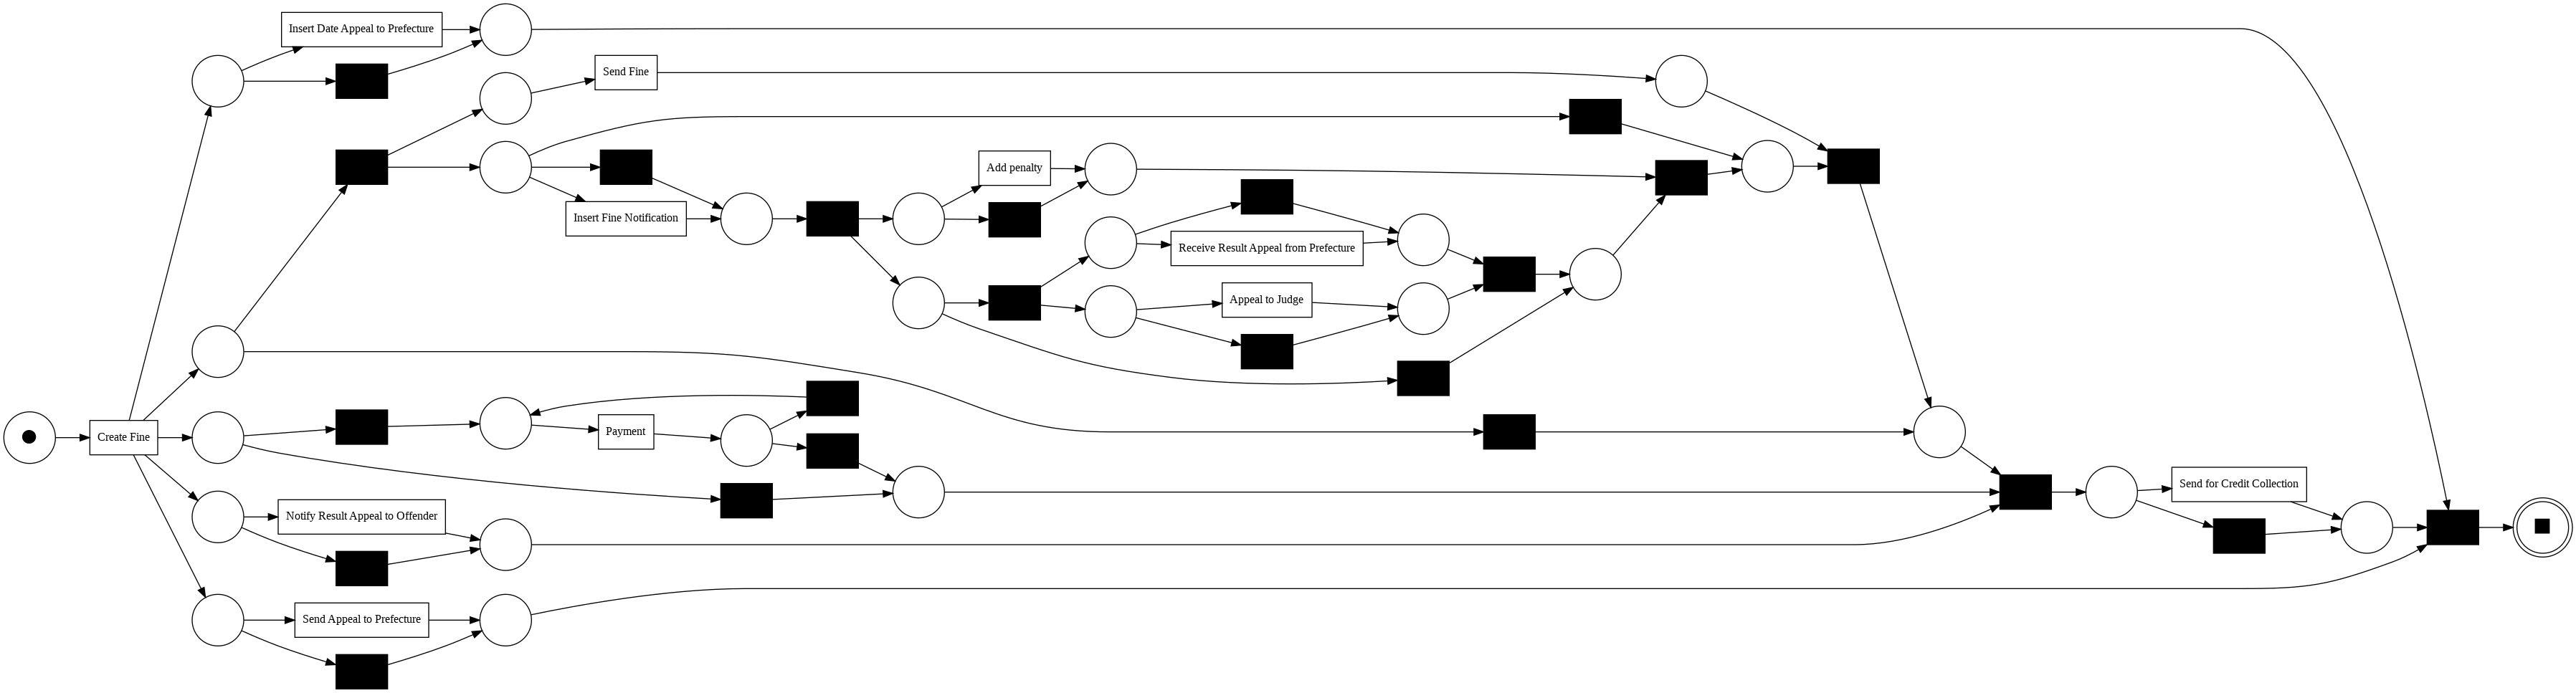

Discovered Petri net transitions (label -> internal name):
  label='Add penalty'                        name=2b9c6c43-da1f-4faa-b2ef-48aad90dea7e
  label='Appeal to Judge'                    name=d4345aa9-5313-4890-8f49-f09c132c4d09
  label='Create Fine'                        name=debd71bf-a3ed-42f9-a6c3-57d0d1a2bc49
  label='Insert Date Appeal to Prefecture'   name=fafbead4-8543-481b-81b6-105133cc3ce5
  label='Insert Fine Notification'           name=a9a35214-77a0-4a7c-8c1a-b199f0f93843
  label='Notify Result Appeal to Offender'   name=90d156ed-ea94-4129-9faa-f47c24596f39
  label='Payment'                            name=d2f15ba0-1cda-4510-89dd-f5b8fd9b399e
  label='Receive Result Appeal from Prefecture'  name=897949fa-0b50-446b-866b-f1827cdbbb36
  label='Send Appeal to Prefecture'          name=6b7aaa64-6c04-4222-b7ec-86678c2540a5
  label='Send Fine'                          name=5be1a4d6-21e0-46d2-84f1-d83a06322233
  label='Send for Credit Collection'         name=2e9d9c52-f623-451

In [9]:
from pm4py.visualization.petri_net import visualizer as pn_vis

net, im, fm = pm4py.discover_petri_net_inductive(log)  # default inductive miner

gviz = pn_vis.apply(net, im, fm)
pn_vis.view(gviz)

print("Discovered Petri net transitions (label -> internal name):")
for t in sorted(net.transitions, key=lambda x: (x.label is None, str(x.label))):
    print(f"  label={t.label!r:35}  name={t.name}")

From the petri net we got, we can answer the following questions:

(a1) With which activities can the process start?

Based on the discovered Petri net, the process can only start with the activity Create Fine.
This is the only visible transition enabled by the initial marking of the model.

(a2) Which activities must be executed in a trace containing an appeal to a judge and in what order?

From the Petri net, it follows that every trace containing an Appeal to Judge must execute Create Fine beforehand.
The model enforces the causal order

Create Fine  ≺  Appeal to Judge
.

Apart from this ordering, the Petri net does not impose any additional mandatory activities that must occur in every trace containing an appeal to a judge; other activities may occur optionally or in different orders.

(a3) Which activities can be executed more than once?

The Petri net contains a loop on the payment branch, which allows the activity Payment to be executed multiple times within the same case.

(a4) Is it possible that the credit collection is involved without the fine being sent to the offender via post?

Yes.
The Petri net allows executions in which Send for Credit Collection is performed without the activity Send Fine having occurred beforehand, since Send Fine is not on every path leading to credit collection.

# b) Behavior Case Frequency

For this question, we recommend using the following event log filtering methods of PM4PY:
- filter_eventually_follows_relation (https://processintelligence.solutions/static/api/2.7.17/generated/pm4py.filtering.filter_eventually_follows_relation.html)
- filter_directly_follows_relation (https://processintelligence.solutions/static/api/2.7.17/generated/pm4py.filtering.filter_directly_follows_relation.html)

In [10]:
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.util import dataframe_utils
from pm4py.algo.filtering.log.attributes import attributes_filter

# activity labels
ADD_PENALTY = "Add penalty"
APPEAL_JUDGE = "Appeal to Judge"
CREATE_FINE = "Create Fine"
INSERT_DATE_APPEAL_PREF = "Insert Date Appeal to Prefecture"
INSERT_FINE_NOTIFICATION = "Insert Fine Notification"
NOTIFY_RESULT = "Notify Result Appeal to Offender"
PAYMENT = "Payment"
RECEIVE_RESULT_PREF = "Receive Result Appeal from Prefecture"
SEND_APPEAL_PREF = "Send Appeal to Prefecture"
SEND_FINE = "Send Fine"
CREDIT_COLLECTION = "Send for Credit Collection"

def to_df(obj):
    """obj can be EventLog or DataFrame; return DataFrame with timestamps converted."""
    if isinstance(obj, pd.DataFrame):
        df = obj.copy()
    else:
        df = log_converter.apply(obj, variant=log_converter.Variants.TO_DATA_FRAME)
    df = dataframe_utils.convert_timestamp_columns_in_df(df)
    return df

def n_cases(obj):
    df = to_df(obj)
    return df[CASE_COL].nunique()

def filter_eventually_follows(lg_or_df, relations, retain=True):
    # Docs: pm4py.filtering.filter_eventually_follows_relation(log, relations, retain=True, activity_key=..., timestamp_key=..., case_id_key=...) :contentReference[oaicite:1]{index=1}
    return pm4py.filtering.filter_eventually_follows_relation(
        lg_or_df,
        relations,
        retain=retain,
        activity_key=ACT_COL,
        timestamp_key=TIME_COL,
        case_id_key=CASE_COL
    )

def filter_directly_follows(lg_or_df, relations, retain=True):
    # Docs: pm4py.filtering.filter_directly_follows_relation(log, relations, retain=True, activity_key=..., timestamp_key=..., case_id_key=...) :contentReference[oaicite:2]{index=2}
    return pm4py.filtering.filter_directly_follows_relation(
        lg_or_df,
        relations,
        retain=retain,
        activity_key=ACT_COL,
        timestamp_key=TIME_COL,
        case_id_key=CASE_COL
    )

def filter_cases_containing_any_activity(lg, acts, retain=True):
    """
    keep cases that contain any activity in `acts` (OR).
    retain=True -> keep such cases; retain=False -> remove such cases.
    """
    filtered = attributes_filter.apply_events(
        lg,
        acts,
        parameters={
            attributes_filter.Parameters.ATTRIBUTE_KEY: ACT_COL,
            attributes_filter.Parameters.POSITIVE: True
        }
    )
    if retain:
        return filtered
    # remove: take all case ids minus those
    all_ids = set(to_df(lg)[CASE_COL].unique())
    keep_ids = all_ids - set(to_df(filtered)[CASE_COL].unique())
    return attributes_filter.apply_events(
        lg,
        list(keep_ids),
        parameters={
            attributes_filter.Parameters.ATTRIBUTE_KEY: CASE_COL,
            attributes_filter.Parameters.POSITIVE: True
        }
    )
# build per-case activity sequence (sorted by timestamp)
df_sorted = df.sort_values([CASE_COL, TIME_COL])
case_acts = df_sorted.groupby(CASE_COL)[ACT_COL].apply(list)
case_times = df_sorted.groupby(CASE_COL)[TIME_COL].apply(list)



In [11]:
b1_obj = filter_eventually_follows(log, [(PAYMENT, CREDIT_COLLECTION)], retain=True)
print(f"b1) {n_cases(b1_obj)} cases are with Payment eventually followed by Send for Credit Collection")

b1) 1013 cases are with Payment eventually followed by Send for Credit Collection


In [12]:
b2_obj = filter_eventually_follows(log, [(ADD_PENALTY, SEND_FINE)], retain=True)
print("b2) #cases with Add penalty eventually followed by Send Fine:", n_cases(b2_obj))

b2) #cases with Add penalty eventually followed by Send Fine: 0


In [13]:
b3_pref1 = filter_eventually_follows(log, [(PAYMENT, INSERT_DATE_APPEAL_PREF)], retain=True)
b3_pref2 = filter_eventually_follows(log, [(PAYMENT, SEND_APPEAL_PREF)], retain=True)
b3_judge = filter_eventually_follows(log, [(PAYMENT, APPEAL_JUDGE)], retain=True)

ids = set(to_df(b3_pref1)[CASE_COL].unique()) | set(to_df(b3_pref2)[CASE_COL].unique()) | set(to_df(b3_judge)[CASE_COL].unique())
print("b3) #cases with Payment eventually followed by (Prefecture-appeal activity OR Appeal to Judge):", len(ids))

b3) #cases with Payment eventually followed by (Prefecture-appeal activity OR Appeal to Judge): 10


In [14]:
has_notify = filter_cases_containing_any_activity(log, [NOTIFY_RESULT], retain=True)
has_any_appeal = filter_cases_containing_any_activity(
    log,
    [APPEAL_JUDGE, INSERT_DATE_APPEAL_PREF, SEND_APPEAL_PREF],
    retain=True
)

ids_notify = set(to_df(has_notify)[CASE_COL].unique())
ids_appeal = set(to_df(has_any_appeal)[CASE_COL].unique())

print("b4) #cases with Notify Result but NO appeal action:", len(ids_notify - ids_appeal))

b4) #cases with Notify Result but NO appeal action: 5


# c) Variants

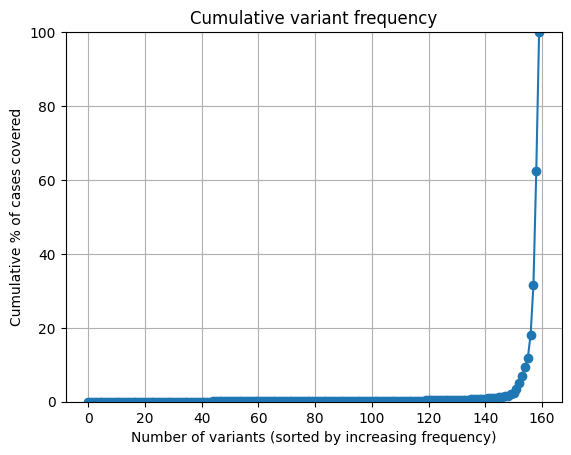

Total variants: 159

Top-5 variants and their case counts:
1. count=26872  variant=('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Send for Credit Collection')
2. count=22078  variant=('Create Fine', 'Payment')
3. count=9631  variant=('Create Fine', 'Send Fine')
4. count=4507  variant=('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Payment')
5. count=1806  variant=('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Payment', 'Payment')


In [15]:
variant_counts =  pm4py.get_variants_as_tuples(log)

vc = pd.DataFrame({
    "variant": list(variant_counts.keys()),
    "count": list(variant_counts.values())
}).sort_values(by="count", ascending=True).reset_index(drop=True)

total_cases = df[CASE_COL].nunique()
cum_cases = vc["count"].cumsum()
cum_pct = cum_cases / total_cases * 100.0

# Add 0th variant point to start at (0,0)
x = np.arange(0, len(vc) + 1)
y = np.concatenate([[0.0], cum_pct.values])

plt.figure()
plt.plot(x, y, marker="o")
plt.xlabel("Number of variants (sorted by increasing frequency)")
plt.ylabel("Cumulative % of cases covered")
plt.title("Cumulative variant frequency")
plt.ylim(0, 100)
plt.grid(True)
plt.show()

print("Total variants:", len(vc))
print("\nTop-5 variants and their case counts:")
top5 = vc.sort_values(by="count", ascending=False).reset_index(drop=True).head(5)
for i, row in top5.iterrows():
    print(f"{i+1}. count={row['count']}  variant={row['variant']}")

A very small number of variants already covers the vast majority of cases, as the cumulative curve rises steeply at the end.
This indicates that the process is highly structured, with only a few dominant execution patterns and many infrequent variants that together account for only a small fraction of the cases.

# d) Case overview

Counts by category:
 open                        13766
closed_paid_full            28718
closed_dismissed              966
closed_credit_collection    28072
Name: count, dtype: int64
Total cases: 71522   (check): 71522


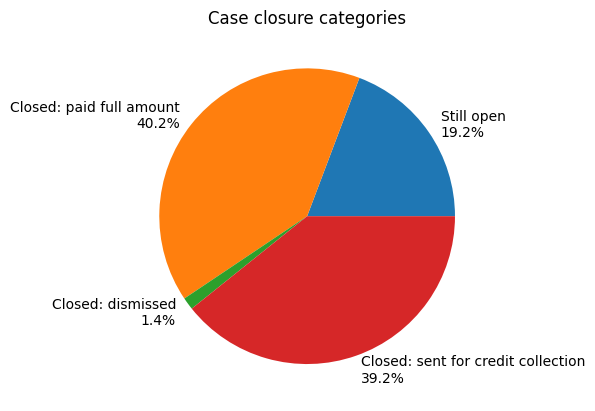

In [16]:
# columns for amounts (may contain NaNs)
FINE_COL = "case:fine"
EXPENSE_COL = "expense"
PENALTY_COL = "penalty"
PAY_COL = "paymentAmount"
DISMISSAL_COL = "dismissal"

# case-level aggregation
case_fine = df_sorted.groupby(CASE_COL)[FINE_COL].first()
case_expense = df_sorted.groupby(CASE_COL)[EXPENSE_COL].max()
case_penalty = df_sorted.groupby(CASE_COL)[PENALTY_COL].max()

# total paid can be multiple payments
case_paid = df_sorted.groupby(CASE_COL)[PAY_COL].sum()

# dismissal: any non-null dismissal in the case
case_dismissed = df_sorted.groupby(CASE_COL)[DISMISSAL_COL].apply(lambda s: s.notna().any())

# credit collection: activity present
case_cc = case_acts.apply(lambda xs: CREDIT_COLLECTION in xs)

# due amount = fine + expense + penalty (treat missing as 0)
fine = case_fine.reindex(case_acts.index).fillna(0.0)
expense = case_expense.reindex(case_acts.index).fillna(0.0)
penalty = case_penalty.reindex(case_acts.index).fillna(0.0)
paid = case_paid.reindex(case_acts.index).fillna(0.0)

due = fine + expense + penalty
case_paid_full = paid >= due

# mutually exclusive categories (as described)
category = pd.Series("open", index=case_acts.index, dtype="object")
category[case_cc] = "closed_credit_collection"
category[~case_cc & case_dismissed] = "closed_dismissed"
category[~case_cc & ~case_dismissed & case_paid_full] = "closed_paid_full"

counts = category.value_counts().reindex(
    ["open", "closed_paid_full", "closed_dismissed", "closed_credit_collection"], fill_value=0
)

print("Counts by category:\n", counts)
print("Total cases:", int(total_cases), "  (check):", int(counts.sum()))

labels = [
    "Still open",
    "Closed: paid full amount",
    "Closed: dismissed",
    "Closed: sent for credit collection",
]
sizes = counts.values
pct = sizes / sizes.sum() * 100

plt.figure()
plt.pie(sizes, labels=[f"{l}\n{p:.1f}%" for l, p in zip(labels, pct)], autopct=None)
plt.title("Case closure categories")
plt.show()

# e) Filtered log

In [18]:
from pm4py.algo.filtering.log.variants import variants_filter
closed_case_ids = set(category[category != "open"].index)  # set is faster
print("Closed cases:", len(closed_case_ids))

closed_df = log[log["case:concept:name"].isin(closed_case_ids)]
closed_log = pm4py.convert_to_event_log(closed_df)

Closed cases: 57756


Top-5 CLOSED variants (count -> variant):
26872 -> ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Send for Credit Collection')
22053 -> ('Create Fine', 'Payment')
3329 -> ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Payment')
1683 -> ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Payment', 'Payment')
1377 -> ('Create Fine', 'Send Fine', 'Payment')


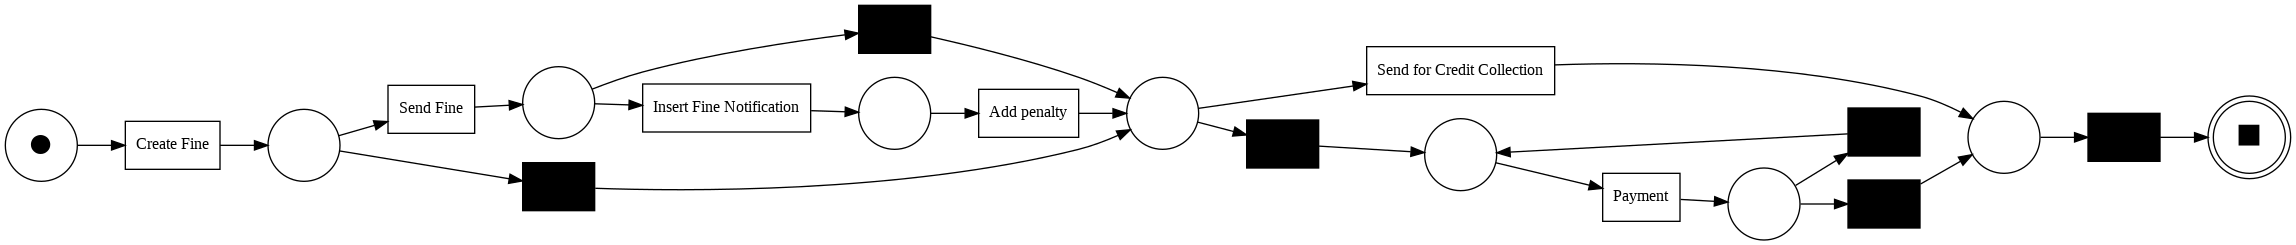


Filtered closed log cases: 55314


In [19]:
from pm4py.statistics.variants.log import get as variants_get


closed_variants = variants_get.get_variants(closed_log)

# Normalize to counts
closed_variant_counts = {}
for v, obj in closed_variants.items():
    closed_variant_counts[v] = obj if isinstance(obj, int) else len(obj)

# Sort by count descending and take top 5
top5_closed = sorted(closed_variant_counts.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top-5 CLOSED variants (count -> variant):")
for c, v in [(cnt, var) for var, cnt in top5_closed]:
    print(f"{int(c)} -> {v}")

top5_variant_keys = [var for var, cnt in top5_closed]

filtered_closed_log = variants_filter.apply(
    closed_log,
    top5_variant_keys,
    parameters={variants_filter.Parameters.POSITIVE: True}
)

net_filt, im_filt, fm_filt = pm4py.discover_petri_net_inductive(filtered_closed_log)
gviz2 = pn_vis.apply(net_filt, im_filt, fm_filt)
pn_vis.view(gviz2)

print(
    "\nFiltered closed log cases:",
    log_converter.apply(filtered_closed_log, variant=log_converter.Variants.TO_DATA_FRAME)["case:concept:name"].nunique()
)

Compared to the Petri net discovered from the full event log (part a)), the model based on the five most frequent closed-case variants is substantially simpler and more structured.
Only the core activities of the fine-handling process are retained, while many infrequent and exceptional activities, in particular those related to appeals, are absent.
Payments occur in a more clearly defined and consistent position late in the process, whereas in the full-log model they can appear at multiple stages.
Moreover, the relation between making a payment and sending for credit collection is tighter: credit collection is mostly an end-of-process step in the filtered model, while in the full model it can be reached through several alternative paths.

# f) Fitness

In [20]:
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay

# Token-based replay the FULL log on the FILTERED model
replayed_traces = token_replay.apply(log, net_filt, im_filt, fm_filt)

# Each element is a dict with keys like:
# 'trace_fitness', 'missing_tokens', 'remaining_tokens', 'consumed_tokens', 'produced_tokens', ...
trace_fitness = np.array([rt.get("trace_fitness", np.nan) for rt in replayed_traces], dtype=float)

perfect = np.isclose(trace_fitness, 1.0, atol=1e-12)
pct_perfect = perfect.mean() * 100.0

# pm4py also has evaluation helpers; try to compute log fitness robustly:
log_fitness = None
try:
    # newer pm4py often provides this convenience function
    fit = pm4py.fitness_token_based_replay(log, net_filt, im_filt, fm_filt)
    log_fitness = fit.get("log_fitness", None)
except Exception as e:
    print("Could not compute log_fitness via pm4py.fitness_token_based_replay:", repr(e))

print(f"Perfectly fitting traces: {pct_perfect:.2f}%")
print("Log fitness:", log_fitness)

replaying log with TBR, completed traces ::   0%|          | 0/159 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/159 [00:00<?, ?it/s]

Perfectly fitting traces: 80.26%
Log fitness: 0.9708997543726612


The log fitness is significantly higher than the percentage of perfectly fitting traces because token-based replay assigns partial credit to traces that deviate only slightly from the model.
Even if a trace is not perfectly replayable, it can still consume and produce most tokens correctly, resulting in a high fitness contribution without being counted as a perfectly fitting trace.